#

# Introduction
## Cart Pole Simulation
The cart pole game includes a cart and a pole, acting as a reverse pendulum above the cart, attached to a pivot point in the center of the cart. **The pendulum will fall to either side of the cart, interacting with the complex cart-pole system and acting on the cart.** The player has the option to increase the force in the rightward or leftward direction. The objective of the game is to **keep the pole within 15 degrees of vertical for as long as possible by shifting the force on the cart**.

## Reinforcement Learning Model
This simulation uses the **Proximal Policy Optimization (PPO) algorithm** from the Stable Baslines3 library. The algorithm works with a reward system to try and maximize score. Since the rewards are tied to surviving more steps in the simulation, the algorithm will train to increase surivival time, improving at playing the cart pole game.

### Model Timeline
- Initialization: defining constants, configuring ML environment
- Reset: restores initial observation state <―――╮――――――╮
- Step: single frame of game is played​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ | ​ ​ ​ ​ ​ ​ ​ ​ ​  ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ |
- Step: step is repeated until losing  ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​| Repeat​ ​ ​ ​ ​ ​ ​ ​ ​ ​ | Repeat
- ...​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ |​ ​ (x10)​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ |​ (~x500)
- Lose: game is lost――――――――――――――╯ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ ​ |
- Iterate: ML model makes changes―――――――――――――╯
- Close: time data is saved and simulation terminated

### Vector Normalization
Input vectors are normalized by wrapping the environment in a vector normalization wrapper before running the trials. **In effect, this scales the environment's inputs so that each input (cart position, cart velocity, pole rotation, and pole angular velocity) is considered similarly when training the model.**


## Physics
Since the cart pole system includes both translational and rotational elements, **both frames of reference need to be considered.**

### Variables:  
- $x$: horizontal location of the center of the cart 
- $v$: translational velocity
- $a$: translational acceleration
- $\theta$: pole angle from vertical (counterclockwise is positive)
- $\omega$: pole angular velocity
- $\alpha$: pole angular acceleration
- $m_c$: cart mass
- $m_p$: pole mass
- $l$: distance from pivot to center of pole
- $g$: Earth gravitational acceleration
- $f$: applied force

### Derivations:
Starting with Newton's 2nd law for the cart and pole center of mass (horizontal):  
$\Sigma F = m_c\:a$  
$\Sigma F_{px} = m_p\: a_{px}$  

Calculate the horizontal location of the pole center of mass:  
$x_{px} = l sin(\theta)$

Using calculus identity, solve for acceleration of pole center of mass:  
$a = \frac{d^2x}{dt^2}$  
$a_{px} = \frac{d^2}{dt^2}[x_{px}] = a + l\alpha\cos(\theta) - m_pl\sin(\theta)\omega^2$

Solve for net horizontal force on pole center of mass:  
$\Sigma F_{px} = m_p(a + l\alpha\cos(\theta) - m_pl\sin(\theta)\omega^2)$

Expand Newton's 2nd law for cart, factor in Newton's 3rd law for pole force on cart:  
$\Sigma F = m_c\:a$  
$f - \Sigma F_{px} = m_c\:a$  
$f = m_c\:a + \Sigma F_{px} = m_c\:a + m_p(a + l\alpha\cos(\theta) - m_pl\sin(\theta)\omega^2)$  
$f = (m_c + m_p)a + m_p l \alpha \cos(\theta) - m_p l \sin(\theta) \omega^2$

Solving for translational acceleration:  
$a = \frac{f-m_pl \alpha \cos(\theta) + m_pl \sin(\theta)\omega^2}{m_c+m_p}$

Solving for rotational acceleration:  
$\Sigma F_{p\perp} = m_p a_{p\perp}$  
$m_p(g\sin(\theta) - a\cos(\theta)) = m_p a_{p\perp}$  
$g\sin(\theta) - a\cos(\theta) = \alpha l$  
$\alpha = \frac{g\sin(\theta) - a\cos(\theta)}{l}$

### Dampening
To prevent excessive energy accumulation in the system $v$ & $\omega$ are dampened each frame by a factor of 0.99 and 0.9 respectively.

### Integration
To calculate velocity, position, and their rotational counterparts, acceleration and angular acceleration are integrated. To preserve computer resources and increase the efficiency of each trial, the Euler method is used to approximate the values to sufficient accuracy. The approximations are as follows:

$v_{t+1} = v_t + a_t * \Delta t$  
$x_{t+1} = x_t + v_t * \Delta t$  

$\omega_{t+1} = \omega_{t} + \alpha_t * \Delta t$  
$\theta_{t+1} = \theta_{t} + \omega_t * \Delta t$  

For the purposes of this simulation, an artificial time step was introduced with each frame/step set to 0.02 seconds or 50 FPS. This means that $\Delta t = 0.02$.

## Rendering 
To render the cart pole system, it was first necessary to determine the top left coordinate of the rectangles, square to the horizontal axis, that enclose the cart and pole elements. For the cart, this amounted to taking $x$, the horizontal position of the cart's center, and subtracting half the width of the cart, 100, to find the horizontal component, and simply taking the constant vertical component of the cart, 520. Together, the rendering position of the cart is $(x - 100, 520)$ in pixels.

On the other hand, since the pole is rotating and has vertical and horizontal components dependent on $\theta$, the angle between the vertical pole and current position of the pole, the rendering position of the pole is more complex. Defining the rendering position of the pole in terms of $\theta$ creates the following functions:  

When $\frac{-\pi}{2}\leq\theta\leq0$:  
$x(\theta) = x -12.5\cos(\theta)$  
$y(\theta) = 520 - 100\cos(\theta) + 12.5\sin(\theta)$

When $0\leq\theta\leq\frac{\pi}{2}$:  
$x(\theta) = x - 100\sin(\theta) - 12.5\cos(\theta)$  
$y(\theta) = 520 - 100\cos(\theta) - 12.5\sin(\theta)$  

Graphed: See Repo

Using the rendering position of the respective elements, they can be rendered separately to visualize the cart pole system.
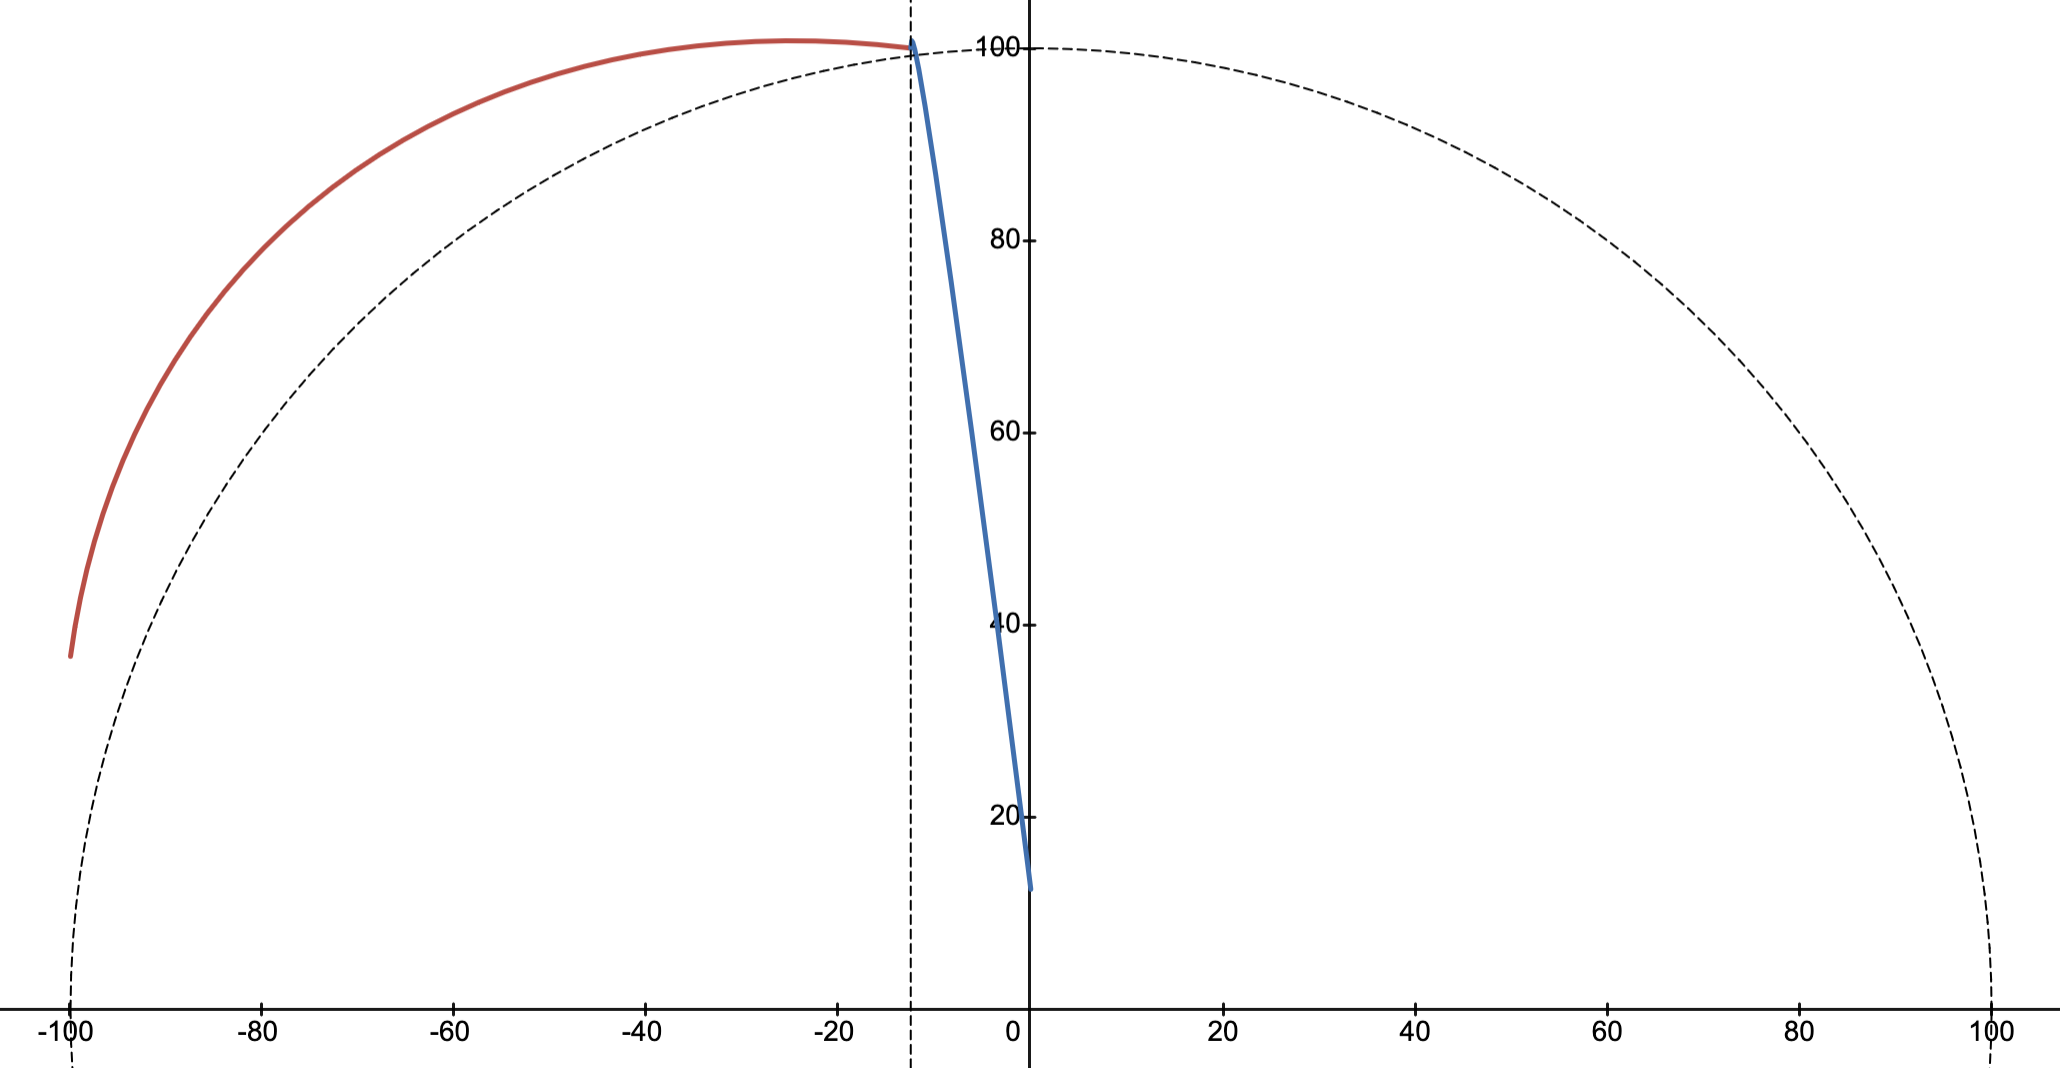

# Cart Pole Environment

In [ ]:
import pygame as pg
import numpy as np
import gymnasium as gym
import sys

class PoleCartEnv(gym.Env):
    def __init__(self, auto_render = False):
        # Constants
        self.g = 9.81
        self.m_c = 1
        self.m_p = .1
        self.l = 2
        self.h = 0.02  # 0.02 simulated seconds between each step

        # End conditions
        self.max_rx = np.deg2rad(15)
        self.min_x = 0
        self.max_x = 1280

        # Pygame initialization flag
        self.screen = None
        self.auto_render = auto_render

        # Machine learning config
        self.quit = False            # Tracks if model should keep running episodes
        self.done = False            # Tracks if current episode has ended
        self.steps = 0
        self.episode_count = -1      # Setting episode counter so 1st trial is trial 1
        self.times = []
        self.step_reward = 1
        self.fail_penalty = -200

        # Action and observation spaces
        self.action_space = gym.spaces.Discrete(2) # 0 = left force, 1 = right force
        self.observation_space = gym.spaces.Box(
            low = np.array([self.min_x, -np.inf, -self.max_rx, -np.inf], dtype=np.float32),
            high = np.array([self.max_x, np.inf, self.max_rx, np.inf], dtype=np.float32),
            dtype = np.float32)
        
        # Restore initial observation state
        self.reset()

    # Defining reset conditions
    def reset(self, *, seed = None, options = None):  # Bunch of extra unused inputs for compatability
        if self.episode_count > 0:
            self.times.append(self.steps * self.h)

        # Resetting kinematic variables
        self.f = 0
        self.x = 640
        self.rx = np.random.uniform(-0.01, 0.01) # Angle set randomly off center (radians)
        self.v = 0
        self.rv = 0
        self.a = 0
        self.ra = 0

        # Reset game state
        self.done = False
        self.steps = 0
    
        # Increase episode counter
        self.episode_count += 1

        # Return observation state
        return self._get_obs(), {}  # Return empty info dict for compatibility

    # Helper function to return observation state
    def _get_obs(self):
        return np.array([self.x, self.v, self.rx, self.rv], dtype = np.float32)
    
    def step(self, action):
        # Applying chosen action
        if action == 0:    # Force left
            self.f -= 0.1
        elif action == 1:  # Force right
            self.f += 0.1

        # Update physics
        self.rx += self.rv * self.h
        self.rv += self.ra * self.h
        self.ra = -(self.g * np.sin(self.rx) - self.a * np.cos(self.rx)) / self.l

        self.x += self.v * self.h
        self.v += self.a * self.h
        self.a = (self.f - self.m_p * self.g * np.cos(self.rx) + self.m_p * self.l * np.power(self.rv, 2) * np.sin(self.rx)) / (self.m_c + self.m_p - self.m_p * np.power(np.cos(self.rx), 2))

        # Apply damping
        self.rv *= 0.99
        self.v *= 0.99

        # Check to see if episode should terminate
        if np.abs(self.rx) > self.max_rx or self.x < self.min_x or self.x > self.max_x:
            self.done = True
            reward = self.fail_penalty/np.log(self.steps + 3) - self.episode_count/100
        else:
            reward = self.step_reward

        # Increase step counter
        self.steps += 1

        # Render step
        if self.auto_render:
            self.render()

        # Return state
        return self._get_obs(), reward, self.done, False, {}  # Truncated = False and empty info dict for compatibility
    
    # Creating a function to render computer's gameplay
    def render(self, mode = "human"):  # Unused input for compatibility
        # Checking to see if Pygame has been initiated
        if self.screen is None:
            # Pygame setup
            pg.init()
            self.clock = pg.time.Clock()
            self.screen = pg.display.set_mode((1280,720))
            pg.display.set_caption("CartPole RL")

            # Creating cart and pole
            self.cart = pg.Surface((200,25))
            self.cart.fill((255, 255, 255))
            self.pole = pg.Surface((25, 100))
            self.pole.fill((255, 255, 255))
            self.pole_original = self.pole.copy()  
            self.pole_original.fill((255, 255, 255))

            # Creating theta meter, timer, and trial counter
            self.font = pg.font.Font(None, 80)
            self.theta_meter = self.font.render("θ: " + str(np.abs(np.round(np.rad2deg(self.rx),2))), False, (255,255,255))
            self.timer = self.font.render(f"Time: {round(self.steps * self.h, 3)}s", False, (255,255,255))
            self.trial_counter = self.font.render(f"Trials: {self.episode_count}", False, (255,255,255))

        # When Pygame window is x'd out, stop the simulation
        for event in pg.event.get():
            if event.type == pg.QUIT:
                self.close()
                
        # Tick clock forward one frame
        self.clock.tick(50)

        # Rendering
        self.screen.fill((0,0,0))
        self.rotated_pole = pg.transform.rotate(self.pole_original, np.rad2deg(self.rx))  # Rotate pole
        self.screen.blit(self.cart, (self.x - 100, 520))
        # Variable equation for rendering position as described in Rendering section
        if self.rx <= 0:
                self.screen.blit(self.rotated_pole, (self.x - 12.5 * np.cos(self.rx), 520 - 100 * np.cos(self.rx) + 12.5 * np.sin(self.rx)))
        else:
                self.screen.blit(self.rotated_pole, (self.x - 100 * np.sin(self.rx) - 12.5 * np.cos(self.rx), 520 - 100 * np.cos(self.rx) - 12.5 * np.sin(self.rx)))
        # Displaying and updating theta meter, timer, and trial counter
        self.screen.blit(self.theta_meter, (1040, 20))
        self.theta_meter = self.font.render("θ: " + str(np.abs(np.round(np.rad2deg(self.rx),2))), False, (255,255,255))
        self.screen.blit(self.timer, (40,20))
        self.timer = self.font.render(f"Time: {round(self.steps * self.h, 3)}s", False, (255,255,255))
        self.screen.blit(self.trial_counter, (520,20))
        self.trial_counter = self.font.render(f"Trials: {self.episode_count}", False, (255,255,255))

        # Updating screen
        pg.display.flip()

    # Creating function to complete actions on simulation closure
    def close(self):
         self.quit = True  # Stop running trials
         np.savetxt("trial_times.csv", self.times, delimiter = ",", fmt="%.3f")
         pg.quit()
         sys.exit()

# Simulation Framework

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from PoleCartEnv import PoleCartEnv

# Environment creation and wrapping
env = PoleCartEnv(auto_render = False)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs = True, norm_reward = False)

# PPO agent training
model = PPO("MlpPolicy", env, verbose = 1)
model.learn(total_timesteps = 1000000)

# Evaluation
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic = True)
    obs, reward, done, info = env.step(action)


# Watching final episode
eval_env = PoleCartEnv(auto_render = True)
eval_env = Monitor(eval_env)
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecNormalize(eval_env, norm_obs = True, norm_reward = False)

obs = eval_env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic = True)
    obs, reward, done, info = eval_env.step(action)

env.close()

# Results

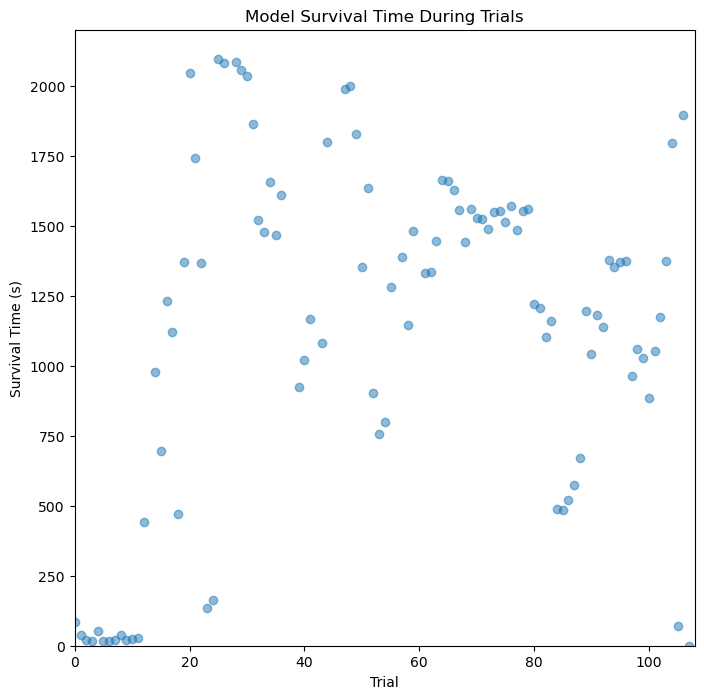

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("trial_times.csv")
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(range(0,len(data)), data, alpha = 0.5)
ax.set_xlim(0, len(data))
ax.set_ylim(0, 2200)
ax.set_xlabel("Trial")
ax.set_ylabel("Survival Time (s)")
ax.set_title("Model Survival Time During Trials");

As shown in the graph, survival time was initially **less than 2 minutes before increasing greatly around trial 15. After trial 15, progress is minimal and variability is high.** Watching the final computer trial, it appears that this variability and lack of growth is due to the model not yet learning how to avoid the walls. After trial 15, the model likely learned how to effectively keep the pole vertical so the only end condition was hitting the side of the environment. **In this sense, the later trial times were solely dependent on the random amount of time it took for the cart to hit one of the side walls.**

# Discussion
## Improving Learning
As mentioned in the previous section, the model did not effectively learn to avoid the walls. This could likely be addressed by **training the model for longer** or by adjusting the **step reward to encourage the model to stay in the center.** An example of this could look like  
step reward $= \frac{1}{1 + |640-x|}$  
By rewarding the model for staying in the center of the screen, the model would learn to tend towards the center and better avoid the issue of running into the boundaries. Similarly, the way the inputs are factored into the learning process could be adjusted to favor considering $x$ and $v$ over $\theta$ and $\omega$. In the current simulation, the inputs are normalized to have similar impacts on the learning process, but this could be changed to encourage the model to focus on staying in bounds.

## Physics Extension
To more accurately simulate a reverse pendulum on a cart, frictional forces between the ground and the cart, and the cart and the pole could be added into the equations. This could possibly extend the model's relevance to real-world applications. Additionally, better estimation techniques such as Riemann sums could be used in place of the Euler estimation to more accurately estimate the integrals for velocity and position. 

## Environment Optimization
To accomplish more training in less time, the cart pole environment should be better optimized. This could involve a number of things, but the most important are **removing rendering, simplifying the physics, and incorporating vectorized operations into.** Firstly, rendering, while a useful visual, consumes significant resources that could be better used to complete more trials. Each frame, the render() function calculates the position of the elements, rotates the pole, and fills the elements. By removing this functionality, the simulation would run faster. Similarly, the physics calculations slow down the simulation considerably. By simplifying the physics and using vectorized operations, the trials could run much faster.
